# Comp 551 Assignment 3

Link to colab version:

https://colab.research.google.com/drive/1N632UmwXtmnjbXGcvYFY7xPxUNCFPySo?usp=sharing


In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from scipy.optimize import check_grad
from keras.datasets.mnist import load_data
import warnings
warnings.filterwarnings('ignore')

# Task 2: Create MLP Model

Note: Task 1 Code comes after the Task 2 Code

## Activation Functions

In [ ]:
class ActivationFunction:    
    def compute(x):
        raise Exception("Compute Not Implemented")
    
    def gradient(z):
        raise Exception("Gradient Not Implemented")

class Relu(ActivationFunction):
    def compute(x):
        return np.maximum(x, 0)
    def gradient(z):
        return np.array(z > 0, dtype=np.float64)

class LeakyRelu(ActivationFunction):
    def compute(x):
        return np.maximum(x, 0.1 * x)
    def gradient(z):
        return np.array(z > 0, dtype=np.float64) * 0.9 + 0.1

class Linear(ActivationFunction):
    def compute(x):
        return x
    def gradient(z):
        return np.ones(z.shape)

class Logistic(ActivationFunction):
    def compute(x):
        return 1./ (1 + np.exp(-x))
    def gradient(z):
        return z * (1-z)

class Softmax(ActivationFunction):
    def compute(x):
        return Logistic.compute(x) / np.sum(Logistic.compute(x))
    def gradient(z):
        return 1 # NOT NEEDED

class Tanh(ActivationFunction):
    def compute(x):
        return np.tanh(x)
    def gradient(z):
        return 1 - (z**2)

## Optimizers

In [ ]:
class Optimizer:
    def train(self, model, x, y):
        raise Exception("Train Not Implemented")

In [ ]:
class SGD(Optimizer):
    def __init__(self, lr=1e-4, max_iters=1e5, eps=1e-8):
        self.lr = lr
        self.max_iters = max_iters
        self.eps = eps
    
    def train(self, model, x, y, return_loss=False):
        norms = np.array([np.inf])
        t = 1
        N = x.shape[0]
        _, _, avg_loss = model.gradient(x[0, np.newaxis, :], 
                                        y[0, np.newaxis, :])
        losses = []
        while np.any(norms > self.eps) and t < self.max_iters:
            gw, gb, l = model.gradient(x[t % N, np.newaxis, :], y[t % N, np.newaxis, :])
            for i in range(model.n_hidden + 1):
                model.weights[i] = model.weights[i] - self.lr * gw[i]
                model.bias[i] = model.bias[i] - self.lr * gb[i]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in (gw + gb)])
            avg_loss = avg_loss * 0.99 + l * 0.01
            if return_loss:
                losses.append(avg_loss)

            if t % 1000 == 0:
                print('Iter:', t, '/', int(self.max_iters), 'Loss: %3.3f' % (avg_loss))
        if return_loss:
            return losses

### Adam Optimizer

#### Adam Hyperparameters (and default values)
lr=1e-3       : learning rate

beta_1=0.9    : beta 1 (see lecture slides)

beta_2=0.999  : beta 2 

batch_size=1  : batch size (in theory this should work but it doesn't seem to train well rn) 

max_iters=1e5 : maximum training iterations

eps=1e-8      : epsilon, if all gradients are less than eps, training halts early

min_lr=1e-6   : minimum learning rate (since learning rate will be decreased automatically when model fails to converge) 

l2_lambda=0   : l2 regularization lambda parameter (0 means no regularization, 1e-4 is a good option when regularizing)

drop_rate=0   : dropout regularization parameter, percent of nodes to drop in each layer (0 means no regularization)

In [ ]:
class Adam(Optimizer):
    def __init__(self, lr=1e-3, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 batch_size=1, 
                 max_iters=1e5, 
                 eps=1e-8, 
                 min_lr=1e-6, 
                 l2_lambda=0, 
                 drop_rate=0):
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.max_iters = max_iters
        self.eps = eps
        self.min_lr = min_lr
        self.batch_size = batch_size
        self.l2_lambda = l2_lambda
        self.drop_rate = drop_rate

    def train(self, model, x, y, return_loss=False):
        t = 1
        Mw = []
        Sw = []
        for w in model.weights:
            Mw.append(np.zeros((w.shape)))
            Sw.append(np.zeros((w.shape)))
        Mb = []
        Sb = []
        for b in model.bias:
            Mb.append(np.zeros((b.shape)))
            Sb.append(np.zeros((b.shape)))

        N = x.shape[0]
        # Initialize avg_loss with the loss of the first point
        gw, gb, avg_loss = model.gradient(x[0, np.newaxis, :], 
                                        y[0, np.newaxis, :], 
                                        l2_lambda=self.l2_lambda)

        losses = []
        best_loss = np.inf
        best_weights = model.weights
        best_bias = model.bias

        past_checkpoint_losses = [np.inf] * 4
        batch_start = 0
        norms = np.array([np.linalg.norm(g) for g in (gw + gb)])
        while np.any(norms > self.eps) and t < self.max_iters:
            if batch_start + self.batch_size <= N:
                gw, gb, l = model.gradient(x[batch_start:batch_start+self.batch_size, :].reshape(self.batch_size, -1), 
                                           y[batch_start:batch_start+self.batch_size, :].reshape(self.batch_size, -1),
                                           l2_lambda=self.l2_lambda,
                                           drop_rate=self.drop_rate)
                batch_start = (batch_start + self.batch_size) % N
            else:
                gw, gb, l = model.gradient(x[batch_start:, :].reshape(N-batch_start, -1), 
                                           y[batch_start:, :].reshape(N-batch_start, -1),
                                           l2_lambda=self.l2_lambda,
                                           drop_rate=self.drop_rate)
                batch_start = 0

            for i in range(model.n_hidden + 1):
                Mw[i] = self.beta_1 * Mw[i] + (1-self.beta_1) * gw[i]
                Sw[i] = self.beta_2 * Sw[i] + (1-self.beta_2) * gw[i] * gw[i]
                model.weights[i] = model.weights[i] - self.lr * (Mw[i] / (1.-(self.beta_1**t))) / (np.sqrt(Sw[i] / (1.-(self.beta_2**t))) + 1e-5)

                Mb[i] = self.beta_1 * Mb[i] + (1-self.beta_1) * gb[i]
                Sb[i] = self.beta_2 * Sb[i] + (1-self.beta_2) * gb[i] * gb[i]
                model.bias[i] = model.bias[i] - self.lr * (Mb[i] / (1.-(self.beta_1**t))) / (np.sqrt(Sb[i] / (1.-(self.beta_2**t))) + 1e-5)
            t += 1
            norms = np.array([np.linalg.norm(g) for g in (gw + gb)])
            avg_loss = avg_loss * 0.9975 + l * 0.0025

            if return_loss:
                losses.append(avg_loss)

            if t > 5000 and t % 50 == 0 and avg_loss < best_loss:
                best_loss = avg_loss
                best_weights = model.weights
                best_bias = model.bias

            if t % 1000 == 0:
                print('Iter:', t, '/', int(self.max_iters), 'Loss: %3.3f' % (avg_loss))

                if (avg_loss / past_checkpoint_losses[(t // 1000) % 4]) >= 1.2 and self.lr > self.min_lr:
                    self.lr = max(self.lr / 3, self.min_lr)
                    print('Decreasing lr to: %.3e' % self.lr)
                    past_checkpoint_losses = [np.inf] * 4
                
                past_checkpoint_losses[(t // 1000) % 4] = avg_loss
        
        if not np.any(norms > self.eps):
            print('Stopping early due to all 0 gradients')
        
        cur_acc = np.mean(np.argmax(model.predict(x), axis=1) == np.argmax(y, axis=1))
        temp_w = model.weights
        temp_b = model.bias
        model.weights = best_weights
        model.bias = best_bias

        best_acc = np.mean(np.argmax(model.predict(x), axis=1) == np.argmax(y, axis=1))

        if cur_acc > best_acc:
            model.weights = temp_w
            model.bias = temp_b
        
        print('Final Model Train Accuracy:', max(cur_acc, best_acc))
        print()

        if return_loss:
            return np.array(losses)

## MLP Model

In [ ]:
class MLP:
    built_in_activation_funcs = {
        'relu': Relu,
        'linear': Linear,
        'logistic': Logistic,
        'log': Logistic,
        'tanh': Tanh,
        'softmax' : Softmax,
        'lrelu' : LeakyRelu
    }

    def __init__(self, x_dim, y_dim, activation_func, hidden_units, optimizer):
        use_he_initialization = False
        # Verify Activation Function
        if type(activation_func) == str:
            try:
                self.act_func = self.built_in_activation_funcs.get(activation_func)
                if activation_func == 'relu':
                    use_he_initialization = True
            except KeyError:
                raise Exception('Activation function must be one of the following strings: ' + ", ".join(self.built_in_activation_funcs.keys()) + ' or a subclass of ActivationFunction')
        else:
            if not issubclass(activation_func, ActivationFunction):
                raise Exception('Activation function must be one of the following strings: ' + ", ".join(self.built_in_activation_funcs.keys()) + ' or a subclass of ActivationFunction')
            else:
                self.act_func = activation_func

        self.n_hidden = len(hidden_units) # Number of hidden layers

        if not isinstance(optimizer, Optimizer):
            raise Exception('Optimizer must be an instance of an Optimizer Object')
        else:
            self.opt = optimizer

        self.weights = [] # weight matrices
        self.bias = []
        last_layer_size = x_dim
        for w in hidden_units:
            if use_he_initialization:
                self.weights.append(np.random.randn(last_layer_size, w) * np.sqrt(2.0 / last_layer_size))
            else:
                xav_val = np.sqrt(6) / np.sqrt(last_layer_size + w)
                self.weights.append(np.random.uniform(-xav_val, xav_val, (last_layer_size, w)))
            self.bias.append(np.zeros((1, w)))
            last_layer_size = w
        self.weights.append(np.random.randn(last_layer_size, y_dim) / y_dim + 0.01)
        self.bias.append(np.random.randn(1, y_dim) * .1)

    def predict(self, x):
        N,D = x.shape
        u = x
        for i in range(self.n_hidden):
            u = self.act_func.compute(np.dot(u, self.weights[i]) + self.bias[i])
        
        yh = Softmax.compute(np.dot(u, self.weights[-1]) + self.bias[-1])
        return yh

    def gradient(self, x, y, l2_lambda=0, drop_rate=0):
        N, D = x.shape
        z = [None] * (self.n_hidden + 1)
        z[0] = x
        for i in range(self.n_hidden):
            mask = np.random.uniform(size=self.weights[i].shape[1])
            temp = self.act_func.compute(np.dot(z[i], self.weights[i]) + self.bias[i])
            temp[:, mask < drop_rate] = 0
            z[i+1] = temp
        
        yh = Softmax.compute(np.dot(z[-1], self.weights[-1]) + self.bias[-1])
        loss = np.mean(-np.log(yh)[np.array(y, dtype=np.bool)])
        
        dw = [None] * (self.n_hidden + 1)
        db = [None] * (self.n_hidden + 1)

        # bias has shape 1xD for each layer with D features
        
        err = yh - y # N x C
        dw[-1] = np.dot(z[-1].T, err) / N # D x C
        db[-1] = np.mean(err, axis=0)# 1 x C

        if l2_lambda != 0:
            loss += (l2_lambda / 2) * np.sum(self.weights[-1]**2)
            dw[-1] += l2_lambda * self.weights[-1]

        for i in range(self.n_hidden-1, -1, -1):
            err = (np.dot(err, self.weights[i+1].T)) * self.act_func.gradient(z[i+1])
            dw[i] = np.dot(z[i].T, err) / N # D x C
            db[i] = np.mean(err, axis=0)# 1 x C

            if l2_lambda != 0:
                loss += (l2_lambda / 2) * np.sum(self.weights[i]**2)
                dw[i] += l2_lambda * self.weights[i]

        return dw, db, loss

    def fit(self, x, y, return_loss=False):
        return self.opt.train(self, x, y, return_loss=return_loss)

# Task 1: Import and Preprocess Data

In [ ]:
def to_onehot(y):
    y_hot = np.zeros((y.size, 10))
    y_hot[np.arange(y.size), y] = 1
    return y_hot

def scale(x):
    return (x / 255)

def shuffle(x, y):
    reorder = np.random.permutation(x.shape[0])
    x = x[reorder, :, :]
    y = y[reorder]
    return x, y

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data() # test and train

x_train, y_train = shuffle(x_train, y_train) # Randomly shuffle the training dataset

x_train_norm, x_test_norm = scale(x_train), scale(x_test)
y_train_hot, y_test_hot = to_onehot(y_train), to_onehot(y_test)

#Task 3: Run experiments

###Experiment 1

In [ ]:
# dimensions
x_dim = 28*28
y_dim = 10

Iter: 1000 / 50000 Loss: 1.811
Iter: 2000 / 50000 Loss: 1.405
Iter: 3000 / 50000 Loss: 1.146
Iter: 4000 / 50000 Loss: 1.040
Iter: 5000 / 50000 Loss: 0.972
Iter: 6000 / 50000 Loss: 0.893
Iter: 7000 / 50000 Loss: 0.895
Iter: 8000 / 50000 Loss: 0.832
Iter: 9000 / 50000 Loss: 0.780
Iter: 10000 / 50000 Loss: 0.717
Iter: 11000 / 50000 Loss: 0.775
Iter: 12000 / 50000 Loss: 0.758
Iter: 13000 / 50000 Loss: 0.707
Iter: 14000 / 50000 Loss: 0.654
Iter: 15000 / 50000 Loss: 0.732
Iter: 16000 / 50000 Loss: 0.704
Iter: 17000 / 50000 Loss: 0.635
Iter: 18000 / 50000 Loss: 0.630
Iter: 19000 / 50000 Loss: 0.718
Iter: 20000 / 50000 Loss: 0.659
Iter: 21000 / 50000 Loss: 0.727
Iter: 22000 / 50000 Loss: 0.634
Iter: 23000 / 50000 Loss: 0.729
Iter: 24000 / 50000 Loss: 0.675
Iter: 25000 / 50000 Loss: 0.736
Iter: 26000 / 50000 Loss: 0.638
Iter: 27000 / 50000 Loss: 0.729
Iter: 28000 / 50000 Loss: 0.792
Iter: 29000 / 50000 Loss: 0.784
Iter: 30000 / 50000 Loss: 0.780
Decreasing lr to: 1.000e-04
Iter: 31000 / 50000 L

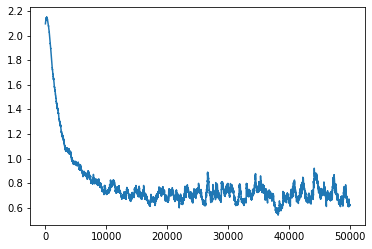

In [ ]:
# ***************************************************************************
# (1) an MLP with no hidden layers
# ***************************************************************************
# model
optimizer1 = Adam(lr=3e-4, max_iters=5e4) 
model1 = MLP(x_dim, y_dim, 'linear', [], optimizer1) 

# train and predict
loss_vals1 = model1.fit(x_train_norm.reshape(-1, x_dim), y_train_hot, return_loss=True)
y_pred1 = model1.predict(x_test_norm.reshape(-1, x_dim))

# test accuracy
accuracy1 = np.mean(np.argmax(y_pred1, 1) == y_test)

plt.plot(np.arange(0, len(loss_vals1)), loss_vals1)
plt.show()

Iter: 1000 / 50000 Loss: 2.179
Iter: 2000 / 50000 Loss: 1.986
Iter: 3000 / 50000 Loss: 1.846
Iter: 4000 / 50000 Loss: 1.737
Iter: 5000 / 50000 Loss: 1.656
Iter: 6000 / 50000 Loss: 1.575
Iter: 7000 / 50000 Loss: 1.534
Iter: 8000 / 50000 Loss: 1.451
Iter: 9000 / 50000 Loss: 1.398
Iter: 10000 / 50000 Loss: 1.343
Iter: 11000 / 50000 Loss: 1.313
Iter: 12000 / 50000 Loss: 1.281
Iter: 13000 / 50000 Loss: 1.239
Iter: 14000 / 50000 Loss: 1.180
Iter: 15000 / 50000 Loss: 1.209
Iter: 16000 / 50000 Loss: 1.151
Iter: 17000 / 50000 Loss: 1.111
Iter: 18000 / 50000 Loss: 1.076
Iter: 19000 / 50000 Loss: 1.108
Iter: 20000 / 50000 Loss: 1.052
Iter: 21000 / 50000 Loss: 1.083
Iter: 22000 / 50000 Loss: 0.976
Iter: 23000 / 50000 Loss: 1.028
Iter: 24000 / 50000 Loss: 0.991
Iter: 25000 / 50000 Loss: 1.058
Iter: 26000 / 50000 Loss: 0.958
Iter: 27000 / 50000 Loss: 1.032
Iter: 28000 / 50000 Loss: 1.048
Iter: 29000 / 50000 Loss: 1.043
Iter: 30000 / 50000 Loss: 1.017
Iter: 31000 / 50000 Loss: 0.935
Iter: 32000 / 500

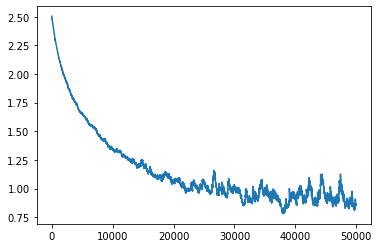

In [ ]:
# ***************************************************************************
# (2) an MLP with a single hidden layer having 128 units and ReLU activations
# ***************************************************************************
# model
optimizer2 = Adam(lr=3e-5, max_iters=5e4)
model2 = MLP(x_dim, y_dim, 'relu', [128], optimizer2)

# train and predict
loss_vals2 = model2.fit(x_train_norm.reshape(-1, x_dim), y_train_hot, return_loss=True)
y_pred2 = model2.predict(x_test_norm.reshape(-1, x_dim))

# test accuracy
accuracy2 = np.mean(np.argmax(y_pred2, 1) == y_test)

plt.plot(np.arange(0, len(loss_vals2)), loss_vals2)
plt.show()

Iter: 1000 / 30000 Loss: 2.182
Iter: 2000 / 30000 Loss: 2.027
Iter: 3000 / 30000 Loss: 1.893
Iter: 4000 / 30000 Loss: 1.799
Iter: 5000 / 30000 Loss: 1.690
Iter: 6000 / 30000 Loss: 1.619
Iter: 7000 / 30000 Loss: 1.567
Iter: 8000 / 30000 Loss: 1.478
Iter: 9000 / 30000 Loss: 1.438
Iter: 10000 / 30000 Loss: 1.378
Iter: 11000 / 30000 Loss: 1.407
Iter: 12000 / 30000 Loss: 1.373
Iter: 13000 / 30000 Loss: 1.330
Iter: 14000 / 30000 Loss: 1.250
Iter: 15000 / 30000 Loss: 1.316
Iter: 16000 / 30000 Loss: 1.285
Iter: 17000 / 30000 Loss: 1.200
Iter: 18000 / 30000 Loss: 1.194
Iter: 19000 / 30000 Loss: 1.282
Iter: 20000 / 30000 Loss: 1.253
Iter: 21000 / 30000 Loss: 1.267
Iter: 22000 / 30000 Loss: 1.112
Iter: 23000 / 30000 Loss: 1.279
Iter: 24000 / 30000 Loss: 1.226
Iter: 25000 / 30000 Loss: 1.344
Iter: 26000 / 30000 Loss: 1.115
Iter: 27000 / 30000 Loss: 1.508
Iter: 28000 / 30000 Loss: 1.541
Decreasing lr to: 1.000e-05
Iter: 29000 / 30000 Loss: 1.502
Iter: 30000 / 30000 Loss: 1.458
Final Model Train Acc

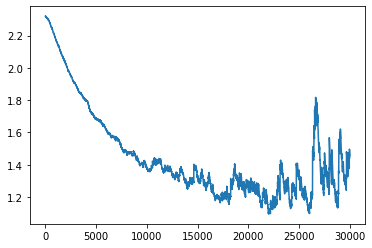

In [ ]:
# ***************************************************************************
# (3) an MLP with 2 hidden layers each having 128 units with ReLU activations
# ***************************************************************************
# model
optimizer3 = Adam(lr=3e-5, max_iters=3e4)
model3 = MLP(x_dim, y_dim, 'relu', [128, 128], optimizer3)

# train and predict
loss_vals3 = model3.fit(x_train_norm.reshape(-1, x_dim), y_train_hot, return_loss=True)
y_pred3 = model3.predict(x_test_norm.reshape(-1, x_dim))

# test accuracy
accuracy3 = np.mean(np.argmax(y_pred3, 1) == y_test)

plt.plot(np.arange(0, len(loss_vals3)), loss_vals3)
plt.show()

In [ ]:
print(f'model 1 accuracy: {accuracy1}')
print(f'model 2 accuracy: {accuracy2}')
print(f'model 3 accuracy: {accuracy3}')

model 1 accuracy: 0.8726
model 2 accuracy: 0.8319
model 3 accuracy: 0.725


### Experiment 2

Iter: 1000 / 30000 Loss: 1.740
Iter: 2000 / 30000 Loss: 1.143
Iter: 3000 / 30000 Loss: 0.743
Iter: 4000 / 30000 Loss: 0.631
Iter: 5000 / 30000 Loss: 0.586
Iter: 6000 / 30000 Loss: 0.489
Iter: 7000 / 30000 Loss: 0.546
Iter: 8000 / 30000 Loss: 0.469
Iter: 9000 / 30000 Loss: 0.346
Iter: 10000 / 30000 Loss: 0.318
Iter: 11000 / 30000 Loss: 0.456
Iter: 12000 / 30000 Loss: 0.365
Iter: 13000 / 30000 Loss: 0.375
Iter: 14000 / 30000 Loss: 0.316
Iter: 15000 / 30000 Loss: 0.299
Iter: 16000 / 30000 Loss: 0.336
Iter: 17000 / 30000 Loss: 0.238
Iter: 18000 / 30000 Loss: 0.269
Iter: 19000 / 30000 Loss: 0.336
Iter: 20000 / 30000 Loss: 0.254
Iter: 21000 / 30000 Loss: 0.326
Decreasing lr to: 3.333e-04
Iter: 22000 / 30000 Loss: 0.216
Iter: 23000 / 30000 Loss: 0.245
Iter: 24000 / 30000 Loss: 0.260
Iter: 25000 / 30000 Loss: 0.261
Iter: 26000 / 30000 Loss: 0.198
Iter: 27000 / 30000 Loss: 0.252
Iter: 28000 / 30000 Loss: 0.320
Decreasing lr to: 1.111e-04
Iter: 29000 / 30000 Loss: 0.217
Iter: 30000 / 30000 Loss:

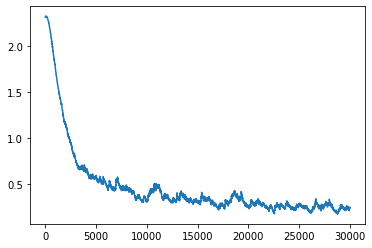

In [ ]:
# ***************************************************************************
# 1) 3rd model copy with sigmoid activation function
# ***************************************************************************
# model
optimizer4 = Adam(lr=1e-3, max_iters=3e4) 
model4 = MLP(x_dim, y_dim, 'logistic', [128, 128], optimizer4)

# train and predict
loss_vals4 = model4.fit(x_train_norm.reshape(-1, x_dim), y_train_hot, return_loss=True)
y_pred4 = model4.predict(x_test_norm.reshape(-1, x_dim))

# test accuracy
accuracy4 = np.mean(np.argmax(y_pred4, 1) == y_test)

plt.plot(np.arange(0, len(loss_vals4)), loss_vals4)
plt.show()

Iter: 1000 / 30000 Loss: 1.475
Iter: 2000 / 30000 Loss: 1.173
Iter: 3000 / 30000 Loss: 0.937
Iter: 4000 / 30000 Loss: 0.902
Iter: 5000 / 30000 Loss: 0.877
Iter: 6000 / 30000 Loss: 0.802
Iter: 7000 / 30000 Loss: 0.769
Iter: 8000 / 30000 Loss: 0.687
Iter: 9000 / 30000 Loss: 0.567
Iter: 10000 / 30000 Loss: 0.487
Iter: 11000 / 30000 Loss: 0.804
Iter: 12000 / 30000 Loss: 0.552
Iter: 13000 / 30000 Loss: 0.529
Iter: 14000 / 30000 Loss: 0.616
Decreasing lr to: 3.333e-04
Iter: 15000 / 30000 Loss: 0.370
Iter: 16000 / 30000 Loss: 0.568
Iter: 17000 / 30000 Loss: 0.298
Iter: 18000 / 30000 Loss: 0.350
Iter: 19000 / 30000 Loss: 0.587
Decreasing lr to: 1.111e-04
Iter: 20000 / 30000 Loss: 0.378
Iter: 21000 / 30000 Loss: 0.570
Iter: 22000 / 30000 Loss: 0.384
Iter: 23000 / 30000 Loss: 0.437
Iter: 24000 / 30000 Loss: 0.379
Iter: 25000 / 30000 Loss: 0.498
Iter: 26000 / 30000 Loss: 0.311
Iter: 27000 / 30000 Loss: 0.409
Iter: 28000 / 30000 Loss: 0.561
Decreasing lr to: 3.704e-05
Iter: 29000 / 30000 Loss: 0.4

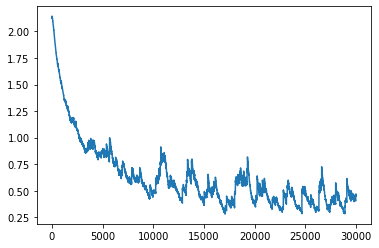

In [ ]:
# ***************************************************************************
# 2) 3rd model copy with tanh activation function
# ***************************************************************************
# model
optimizer5 = Adam(lr=1e-3, max_iters=3e4) 
model5 = MLP(x_dim, y_dim, 'tanh', [128, 128], optimizer5)

# train and predict
loss_vals5 = model5.fit(x_train_norm.reshape(-1, x_dim), y_train_hot, return_loss=True)
y_pred5 = model5.predict(x_test_norm.reshape(-1, x_dim))

# test accuracy
accuracy5 = np.mean(np.argmax(y_pred5, 1) == y_test)

plt.plot(np.arange(0, len(loss_vals5)), loss_vals5)
plt.show()

In [ ]:
print(f'model 3 (ReLU base) accuracy: {accuracy3}')
print(f'model 4 (sigmoid) accuracy: {accuracy4}')
print(f'model 5 (tanh) accuracy: {accuracy5}')

model 3 (ReLU base) accuracy: 0.725
model 4 (sigmoid) accuracy: 0.9503
model 5 (tanh) accuracy: 0.9331


### Experiment 3

Iter: 1000 / 50000 Loss: 1.965
Iter: 2000 / 50000 Loss: 1.571
Iter: 3000 / 50000 Loss: 1.327
Iter: 4000 / 50000 Loss: 1.220
Iter: 5000 / 50000 Loss: 1.210
Iter: 6000 / 50000 Loss: 1.161
Iter: 7000 / 50000 Loss: 1.438
Iter: 8000 / 50000 Loss: 1.109
Iter: 9000 / 50000 Loss: 1.167
Iter: 10000 / 50000 Loss: 1.025
Iter: 11000 / 50000 Loss: 1.659
Iter: 12000 / 50000 Loss: 1.483
Decreasing lr to: 3.333e-05
Iter: 13000 / 50000 Loss: 1.420
Iter: 14000 / 50000 Loss: 1.175
Iter: 15000 / 50000 Loss: 1.465
Iter: 16000 / 50000 Loss: 1.306
Iter: 17000 / 50000 Loss: 1.242
Iter: 18000 / 50000 Loss: 1.384
Iter: 19000 / 50000 Loss: 1.527
Iter: 20000 / 50000 Loss: 1.501
Iter: 21000 / 50000 Loss: 1.797
Decreasing lr to: 1.111e-05
Iter: 22000 / 50000 Loss: 1.237
Iter: 23000 / 50000 Loss: 1.686
Iter: 24000 / 50000 Loss: 1.533
Iter: 25000 / 50000 Loss: 1.723
Iter: 26000 / 50000 Loss: 1.094
Iter: 27000 / 50000 Loss: 1.906
Iter: 28000 / 50000 Loss: 2.398
Decreasing lr to: 3.704e-06
Iter: 29000 / 50000 Loss: 1.9

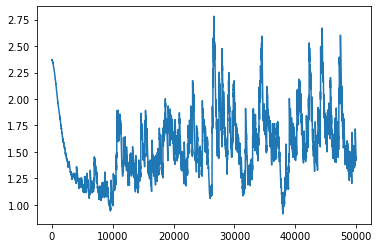

In [ ]:
# ***************************************************************************
# MLP with 2 hidden layers, 128 units, ReLU activations w/ L2 regularization
# ***************************************************************************
# model
optimizer6 = Adam(lr=1e-4, l2_lambda=1e-4, max_iters=5e4)
model6 = MLP(x_dim, y_dim, 'relu', [128, 128], optimizer6)

# train and predict
loss_vals6 = model6.fit(x_train_norm.reshape(-1, x_dim), y_train_hot, return_loss=True)
y_pred6 = model6.predict(x_test_norm.reshape(-1, x_dim))

# test accuracy
accuracy6 = np.mean(np.argmax(y_pred6, 1) == y_test)

plt.plot(np.arange(0, len(loss_vals6)), loss_vals6)
plt.show()

In [ ]:
print(f'model 3 accuracy: {accuracy3}')
print(f'model 6 w/ L2 regularization accuracy: {accuracy6}')

model 3 accuracy: 0.725
model 6 w/ L2 regularization accuracy: 0.8198


### Experiment 4



Iter: 1000 / 30000 Loss: 11.910
Iter: 2000 / 30000 Loss: 8.840
Iter: 3000 / 30000 Loss: 6.609
Iter: 4000 / 30000 Loss: 4.853
Iter: 5000 / 30000 Loss: 4.077
Iter: 6000 / 30000 Loss: 3.739
Iter: 7000 / 30000 Loss: 3.950
Iter: 8000 / 30000 Loss: 3.263
Iter: 9000 / 30000 Loss: 2.882
Iter: 10000 / 30000 Loss: 2.864
Iter: 11000 / 30000 Loss: 3.073
Iter: 12000 / 30000 Loss: 3.101
Iter: 13000 / 30000 Loss: 2.567
Iter: 14000 / 30000 Loss: 2.572
Iter: 15000 / 30000 Loss: 2.580
Iter: 16000 / 30000 Loss: 2.420
Iter: 17000 / 30000 Loss: 2.342
Iter: 18000 / 30000 Loss: 2.416
Iter: 19000 / 30000 Loss: 2.906
Iter: 20000 / 30000 Loss: 2.357
Iter: 21000 / 30000 Loss: 2.211
Iter: 22000 / 30000 Loss: 2.130
Iter: 23000 / 30000 Loss: 2.555
Iter: 24000 / 30000 Loss: 2.313
Iter: 25000 / 30000 Loss: 2.433
Iter: 26000 / 30000 Loss: 2.553
Iter: 27000 / 30000 Loss: 2.743
Iter: 28000 / 30000 Loss: 3.031
Decreasing lr to: 1.000e-06
Iter: 29000 / 30000 Loss: 2.969
Iter: 30000 / 30000 Loss: 2.523
Final Model Train Ac

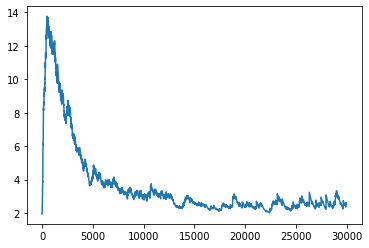

In [ ]:
# ***************************************************************************
# MLP with 2 hidden layers, 128 units, ReLU activations w/ unnormalized images
# ***************************************************************************
# model
optimizer7 = Adam(lr=3e-6, max_iters=3e4)
model7 = MLP(x_dim, y_dim, 'relu', [128, 128], optimizer7)

# **** Replace x.reshape()... with unnormalized images ****

# train and predict
loss_vals7 = model7.fit(x_train.reshape(-1, x_dim), y_train_hot, return_loss=True)
y_pred7 = model7.predict(x_test.reshape(-1, x_dim))

# test accuracy
accuracy7 = np.mean(np.argmax(y_pred7, 1) == y_test)

plt.plot(np.arange(0, len(loss_vals7)), loss_vals7)
plt.show()

In [ ]:
print(f'model 3 accuracy: {accuracy3}')
print(f'model 7 w/ unnormalized images accuracy: {accuracy7}')

model 3 accuracy: 0.725
model 7 w/ unnormalized images accuracy: 0.2225


### Experiment 5 ("creativity section")

Iter: 1000 / 30000 Loss: 1.737
Iter: 2000 / 30000 Loss: 1.209
Iter: 3000 / 30000 Loss: 0.848
Iter: 4000 / 30000 Loss: 0.714
Iter: 5000 / 30000 Loss: 0.644
Iter: 6000 / 30000 Loss: 0.510
Iter: 7000 / 30000 Loss: 0.577
Iter: 8000 / 30000 Loss: 0.461
Iter: 9000 / 30000 Loss: 0.386
Iter: 10000 / 30000 Loss: 0.387
Iter: 11000 / 30000 Loss: 0.497
Iter: 12000 / 30000 Loss: 0.382
Iter: 13000 / 30000 Loss: 0.377
Iter: 14000 / 30000 Loss: 0.295
Iter: 15000 / 30000 Loss: 0.314
Iter: 16000 / 30000 Loss: 0.349
Iter: 17000 / 30000 Loss: 0.304
Iter: 18000 / 30000 Loss: 0.274
Iter: 19000 / 30000 Loss: 0.340
Iter: 20000 / 30000 Loss: 0.273
Iter: 21000 / 30000 Loss: 0.329
Iter: 22000 / 30000 Loss: 0.225
Iter: 23000 / 30000 Loss: 0.324
Iter: 24000 / 30000 Loss: 0.256
Iter: 25000 / 30000 Loss: 0.260
Iter: 26000 / 30000 Loss: 0.191
Iter: 27000 / 30000 Loss: 0.254
Iter: 28000 / 30000 Loss: 0.343
Decreasing lr to: 3.333e-04
Iter: 29000 / 30000 Loss: 0.211
Iter: 30000 / 30000 Loss: 0.216
Final Model Train Acc

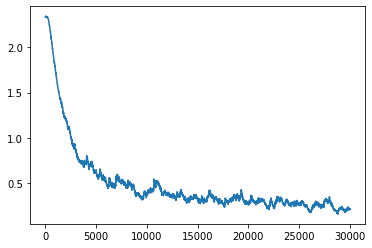

In [ ]:
# ***************************************************************************
# MLP with 3 hidden layers, 256, 128, 128 units, Logistic
# ***************************************************************************
# model
optimizer9 = Adam(lr=1e-3, max_iters=3e4)
model9 = MLP(x_dim, y_dim, 'logistic', [256, 128, 128], optimizer9)

# train and predict
loss_vals9 = model9.fit(x_train_norm.reshape(-1, x_dim), y_train_hot, return_loss=True)
y_pred9 = model9.predict(x_test_norm.reshape(-1, x_dim))

# test accuracy
accuracy9 = np.mean(np.argmax(y_pred9, 1) == y_test)

plt.plot(np.arange(0, len(loss_vals9)), loss_vals9)
plt.show()

In [ ]:
print(f'model 4 accuracy: {accuracy4}')
print(f'model 9 w/ extra layer: {accuracy9}')

model 4 accuracy: 0.9503
model 9 w/ extra layer: 0.952


Iter: 1000 / 100000 Loss: 1.402
Stopping early due to all 0 gradients
Final Model Train Accuracy: 0.7929333333333334



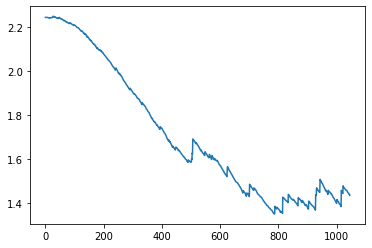

In [ ]:
# ***************************************************************************
# MLP with 2 hidden layers, 128 units, Leaky Relu Activations
# ***************************************************************************
# model
optimizer10 = Adam(lr=1e-3, max_iters=1e5)
model10 = MLP(x_dim, y_dim, 'lrelu', [128, 128], optimizer10)

# train and predict
loss_vals10 = model10.fit(x_train_norm.reshape(-1, x_dim), y_train_hot, return_loss=True)
y_pred10 = model10.predict(x_test_norm.reshape(-1, x_dim))

# test accuracy
accuracy10 = np.mean(np.argmax(y_pred10, 1) == y_test)

plt.plot(np.arange(0, len(loss_vals10)), loss_vals10)
plt.show()

In [ ]:
print(f'model 3 accuracy: {accuracy3}') # Regular Relu 2 layers
print(f'model 10 accuracy: {accuracy10}') # Leaky Relu 2 layers

model 3 accuracy: 0.725
model 10 accuracy: 0.8011
